# Converting Raw Text into Sequence Data
:label:`sec_text-sequence`

Throughout this book,
we will often work with text data
represented as sequences
of words, characters, or word pieces.
To get going, we will need some basic
tools for converting raw text
into sequences of the appropriate form.
Typical preprocessing pipelines
execute the following steps:

1. Load text as strings into memory.
1. Split the strings into tokens (e.g., words or characters).
1. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.
1. Convert the text into sequences of numerical indices.


In [1]:
import collections
import random
import re
import torch
from d2l import torch as d2l

## Reading the Dataset

Here, we will work with H. G. Wells'
[The Time Machine](http://www.gutenberg.org/ebooks/35),
a book containing just over 30,000 words.
While real applications will typically
involve significantly larger datasets,
this is sufficient to demonstrate
the preprocessing pipeline.
The following `_download` method
(**reads the raw text into a string**).


In [2]:
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

For simplicity, we ignore punctuation and capitalization when preprocessing the raw text.


In [3]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization

*Tokens* are the atomic (indivisible) units of text.
Each time step corresponds to 1 token,
but what precisely constitutes a token is a design choice.
For example, we could represent the sentence
"Baby needs a new pair of shoes"
as a sequence of 7 words,
where the set of all words comprise
a large vocabulary (typically tens
or hundreds of thousands of words).
Or we would represent the same sentence
as a much longer sequence of 30 characters,
using a much smaller vocabulary
(there are only 256 distinct ASCII characters).
Below, we tokenize our preprocessed text
into a sequence of characters.


In [4]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary

These tokens are still strings.
However, the inputs to our models
must ultimately consist
of numerical inputs.
[**Next, we introduce a class
for constructing *vocabularies*,
i.e., objects that associate
each distinct token value
with a unique index.**]
First, we determine the set of unique tokens in our training *corpus*.
We then assign a numerical index to each unique token.
Rare vocabulary elements are often dropped for convenience.
Whenever we encounter a token at training or test time
that had not been previously seen or was dropped from the vocabulary,
we represent it by a special "&lt;unk&gt;" token,
signifying that this is an *unknown* value.


In [5]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

We now [**construct a vocabulary**] for our dataset,
converting the sequence of strings
into a list of numerical indices.
Note that we have not lost any information
and can easily convert our dataset
back to its original (string) representation.


In [6]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## Putting It All Together

Using the above classes and methods,
we [**package everything into the following
`build` method of the `TimeMachine` class**],
which returns `corpus`, a list of token indices, and `vocab`,
the vocabulary of *The Time Machine* corpus.
The modifications we did here are:
(i) we tokenize text into characters, not words,
to simplify the training in later sections;
(ii) `corpus` is a single list, not a list of token lists,
since each text line in *The Time Machine* dataset
is not necessarily a sentence or paragraph.


In [7]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

## Exploratory Language Statistics
:label:`subsec_natural-lang-stat`

Using the real corpus and the `Vocab` class defined over words,
we can inspect basic statistics concerning word use in our corpus.
Below, we construct a vocabulary from words used in *The Time Machine*
and print the ten most frequently occurring of them.


In [8]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Note that (**the ten most frequent words**)
are not all that descriptive.
You might even imagine that
we might see a very similar list
if we had chosen any book at random.
Articles like "the" and "a",
pronouns like "i" and "my",
and prepositions like "of", "to", and "in"
occur often because they serve common syntactic roles.
Such words that are common but not particularly descriptive
are often called (***stop words***) and,
in previous generations of text classifiers
based on so-called bag-of-words representations,
they were most often filtered out.
However, they carry meaning and
it is not necessary to filter them out
when working with modern RNN- and
Transformer-based neural models.
If you look further down the list,
you will notice
that word frequency decays quickly.
The $10^{\textrm{th}}$ most frequent word
is less than $1/5$ as common as the most popular.
Word frequency tends to follow a power law distribution
(specifically the Zipfian) as we go down the ranks.
To get a better idea, we [**plot the figure of the word frequency**].


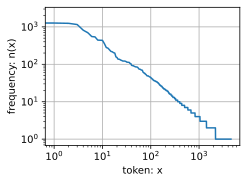

In [9]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

After dealing with the first few words as exceptions,
all the remaining words roughly follow a straight line on a log--log plot.
This phenomenon is captured by *Zipf's law*,
which states that the frequency $n_i$
of the $i^\textrm{th}$ most frequent word is:

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

which is equivalent to

$$\log n_i = -\alpha \log i + c,$$

where $\alpha$ is the exponent that characterizes
the distribution and $c$ is a constant.
This should already give us pause for thought if we want
to model words by counting statistics.
After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But [**what about the other word combinations, such as two consecutive words (bigrams), three consecutive words (trigrams)**], and beyond?
Let's see whether the bigram frequency behaves in the same manner as the single word (unigram) frequency.


In [10]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book---"the time". Furthermore, let's see whether the trigram frequency behaves in the same manner.


In [11]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

Now, let's [**visualize the token frequency**] among these three models: unigrams, bigrams, and trigrams.


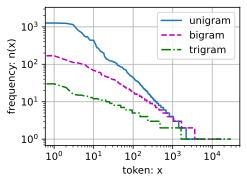

In [12]:
freqs = [freq for token, freq in vocab.token_freqs]
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

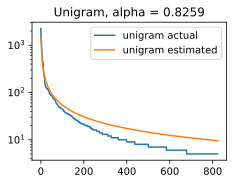

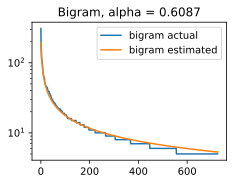

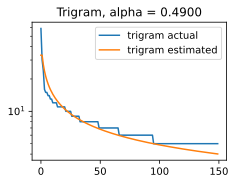

In [96]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

words = text.split()
unigram_vocab = Vocab(words, min_freq=5)

bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens, min_freq=5)

trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens, min_freq=5)

unigram_vocab: list[tuple[str, int]] = [(a, b) for (a, b) in unigram_vocab.token_freqs if b >= 0]
bigram_vocab: list[tuple[str, int]] = [(a, b) for (a, b) in bigram_vocab.token_freqs if b >= 0]
trigram_vocab: list[tuple[str, int]] = [(a, b) for (a, b) in trigram_vocab.token_freqs if b >= 0]

vocab_list = [('unigram', unigram_vocab), ('bigram', bigram_vocab), ('trigram', trigram_vocab)]

# Function to calculate the sum of squared differences, including initial scale
def zipf_cost_with_scale(params, freqs):
    alpha, initial_scale = params
    N = len(freqs)
    rank = np.arange(1, N + 1)
    estimated_freqs = initial_scale * (rank ** (-alpha))
    return np.sum((freqs - estimated_freqs) ** 2)

# Loop through each vocabulary and perform optimization
results = {}
for name, vocab in vocab_list:
    freqs = [freq for token, freq in vocab]
    initial_params = [1.0, freqs[0]]  # Initial guesses for alpha and initial_scale
    opt_result = minimize(zipf_cost_with_scale, initial_params, args=(freqs,))
    results[name] = opt_result.x  # Store the optimized parameters

# Function to plot the results
def plot_freqs(name, freqs, alpha, initial_scale, filename = None):
    y_vals = [initial_scale * ((i + 1) ** (-alpha) if i != 0 else 0.0) for i in range(len(freqs))]
    y_vals[0] = y_vals[1]  # Adjust the first value
    x_vals = range(len(freqs))
    plt.figure()
    plt.plot(x_vals, freqs, label=f'{name} actual')
    plt.plot(x_vals, y_vals, label=f'{name} estimated')
    plt.yscale('log')
    plt.title(f"{name.capitalize()}, alpha = {alpha:.4f}")
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

# Plotting for each vocabulary
for i, (name, opt_params) in enumerate(results.items()):
    vocab_freqs = [freq for token, freq in globals()[f'{name}_vocab']]
    plot_freqs(name, vocab_freqs, *opt_params, f'../../Exercises/9_recurrent-neural-networks_2_{i}.png')

In [93]:
_unigram = [(a, b) for (a, b) in unigram_vocab.token_freqs if b >= 5]
_bigram = [(a, b) for (a, b) in bigram_vocab.token_freqs if b >= 5]
_trigram = [(a, b) for (a, b) in trigram_vocab.token_freqs if b >= 5]

This figure is quite exciting.
First, beyond unigram words, sequences of words
also appear to be following Zipf's law,
albeit with a smaller exponent
$\alpha$ in :eqref:`eq_zipf_law`,
depending on the sequence length.
Second, the number of distinct $n$-grams is not that large.
This gives us hope that there is quite a lot of structure in language.
Third, many $n$-grams occur very rarely.
This makes certain methods unsuitable for language modeling
and motivates the use of deep learning models.
We will discuss this in the next section.


## Summary

Text is among the most common forms of sequence data encountered in deep learning.
Common choices for what constitutes a token are characters, words, and word pieces.
To preprocess text, we usually (i) split text into tokens; (ii) build a vocabulary to map token strings to numerical indices; and (iii) convert text data into token indices for models to manipulate.
In practice, the frequency of words tends to follow Zipf's law. This is true not just for individual words (unigrams), but also for $n$-grams.


## Exercises

1. In the experiment of this section, tokenize text into words and vary the `min_freq` argument value of the `Vocab` instance. Qualitatively characterize how changes in `min_freq` impact the size of the resulting vocabulary.
1. Estimate the exponent of Zipfian distribution for unigrams, bigrams, and trigrams in this corpus.
1. Find some other sources of data (download a standard machine learning dataset, pick another public domain book,
   scrape a website, etc). For each, tokenize the data at both the word and character levels. How do the vocabulary sizes compare with *The Time Machine* corpus at equivalent values of `min_freq`. Estimate the exponent of the Zipfian distribution corresponding to the unigram and bigram distributions for these corpora. How do they compare with the values that you observed for *The Time Machine* corpus?


[Discussions](https://discuss.d2l.ai/t/118)
